In [29]:
import numpy as np
import mplhep as hep
import matplotlib.pyplot as plt
import uproot as up
import pandas as pd 
import awkward as ak
from numba_stats import crystalball,crystalball_ex, norm, expon, voigt, truncexpon
from iminuit.cost import ExtendedBinnedNLL,ExtendedUnbinnedNLL, LeastSquares
from iminuit import Minuit
import os, sys
import yaml
import xgboost as xgb
from sklearn.model_selection import train_test_split

os.environ["HOMELUDO"]="/home/submit/mori25/"
os.environ["DPLUDO"]="/work/submit/mori25/Darkphotons_ludo/"
sys.path.append('/work/submit/mori25/Darkphotons_ludo/BDT')

from training_offline import Trainer, plot_ROC


def load_analysis_config():
    try:
        with open(os.path.join(os.environ["DPLUDO"],"config/analysis_config.yml"), "r") as f:
            config = yaml.load(f, Loader=yaml.FullLoader)
        return config

    except Exception as e: 
        raise e
    
config = load_analysis_config()

fYMC = up.open(os.path.join(config["locations"]["sPlot"], "files/data_withSWeight_Y_MC1M.root:RooTreeDataStore_dataWithSWeights_data_full")).arrays()
fYData = up.open(os.path.join(config["locations"]["sPlot"], "files/data_withSWeight_Y_data1M.root:RooTreeDataStore_dataWithSWeights_data_full")).arrays()

fYMC = fYMC[abs(fYMC["Mm_kin_eta"])<6]
fYData = fYData[abs(fYData["Mm_kin_eta"])<6]

fJpsiMC = up.open(os.path.join(config["locations"]["sPlot"], "files/data_withSWeight_Jpsi_MC1M.root:RooTreeDataStore_dataWithSWeights_data_full")).arrays()
fJpsiData = up.open(os.path.join(config["locations"]["sPlot"], "files/data_withSWeight_Jpsi_data1M.root:RooTreeDataStore_dataWithSWeights_data_full")).arrays()


In [30]:
print(os.path.join(config["locations"]["sPlot"], "files/data_withSWeight_Y_MC.root:RooTreeDataStore_dataWithSWeights_data_full"))

/data/submit/mori25/dark_photons_ludo/DimuonTrees/sPlot/files/data_withSWeight_Y_MC.root:RooTreeDataStore_dataWithSWeights_data_full


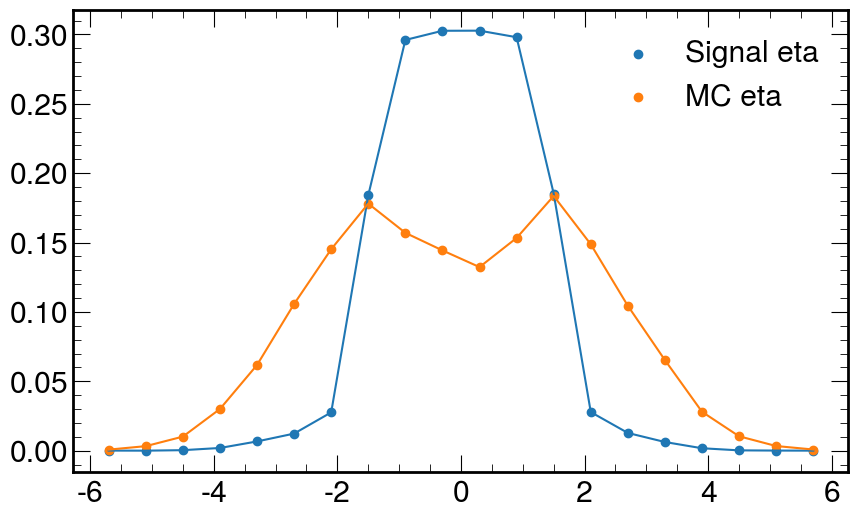

In [31]:
#Calculating eta corrections on the MC 
#MC correction based on eta 
nbins_correction = 20
histSEta,_ = np.histogram(fYData["Mm_kin_eta"],nbins_correction,weights=fYData["sigYield_sw"], range=(-6,6),  density=True) #range=(-8.38,6.9),-
histMCEta,edges = np.histogram(fYMC["Mm_kin_eta"],nbins_correction, weights = fYMC["sigYield_sw"], range=(-6,6), density=True)
weight_hist = np.where(histMCEta == 0, 0, histSEta/histMCEta)  

hep.style.use("CMS")
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(0.5*(edges[:-1] + edges[1:]),histSEta, label = "Signal eta" )
ax.scatter(0.5*(edges[:-1] + edges[1:]),histMCEta, label = "MC eta")
ax.plot(0.5*(edges[:-1] + edges[1:]),histSEta,)
ax.plot(0.5*(edges[:-1] + edges[1:]),histMCEta,)
# ax.scatter(0.5*(edges[:-1] + edges[1:]),weight_hist,)
ax.legend()

corrections = weight_hist[np.digitize(fYMC["Mm_kin_eta"], edges) - 1]
corrections = corrections/np.sum(corrections)

In [32]:
"""
A first study of the efficiency of the BDT on the Y peak. Here look at the BDT trained on Y

"""

#These are the  s/sqrt(b) - optimized cuts. s and b discerned by simple mass cut 
cutYDataId =  0.45
cutYDataBdt = 0.652

print(f"Study efficiency of cuts on Jpsi peak \nID cut: {cutYDataId}\nBDT cut: {cutYDataBdt}")

#The BDT results before the cut
scoreYData = fYData["forest_standard_Y_mva"]
scoreYMC = fYMC["forest_standard_Y_mva"]

#The total signal yields as for the sPlot weights before cuts
YdataTotalYield = np.sum(fYData["sigYield_sw"])
YMCTotalYield = np.sum(fYMC["sigYield_sw"])
print("Total data signal yield: ", YdataTotalYield)
print("Total MC signal yield: ", YMCTotalYield, "\n\n")

#compute corrected weights
corr_weights = 0.5*(corrections*YMCTotalYield + fYMC["sigYield_sw"])

nbins = 100
histYB,_ = np.histogram(scoreYData,nbins,(0,1),False,fYData["bkgYield_sw"])
histYS,xe = np.histogram(scoreYData,nbins,(0,1),False,fYData["sigYield_sw"])
histYMC,_ = np.histogram(scoreYMC,nbins,(0,1),False, fYMC["sigYield_sw"])
histYMC_corrected,_ = np.histogram(scoreYMC,nbins,(0,1),False,corr_weights)

dx = xe[1]-xe[0]
x = 0.5*(xe[:-1]+xe[1:])

#The event cuts on the ID
dataCutOnIDY = (fYData["Muon_softMva1"] > cutYDataId) & (fYData["Muon_softMva2"]> cutYDataId)  
MCCutOnIDY = (fYMC["Muon_softMva1"] > cutYDataId) & (fYMC["Muon_softMva2"] > cutYDataId)     

print("Efficiency data ID cut: ", np.sum(fYData["sigYield_sw"][dataCutOnIDY])/YdataTotalYield)
print("Efficiency MC ID cut: ", np.sum(fYMC["sigYield_sw"][MCCutOnIDY])/YMCTotalYield, "\n\n")
print("Efficiency corrected MC ID cut: ", np.sum(corr_weights[MCCutOnIDY])/YMCTotalYield, "\n\n")

histYB_IDcut,_ = np.histogram(scoreYData[dataCutOnIDY],nbins,(0,1),False,fYData["bkgYield_sw"][dataCutOnIDY])
histYS_IDcut,_ = np.histogram(scoreYData[dataCutOnIDY],nbins,(0,1),False,fYData["sigYield_sw"][dataCutOnIDY])
histYMC_IDcut,_ = np.histogram(scoreYMC[MCCutOnIDY],nbins,(0,1),False,fYMC["sigYield_sw"][MCCutOnIDY])
histYMC_corr_IDcut,_ = np.histogram(scoreYMC[MCCutOnIDY],nbins,(0,1),False,corr_weights[MCCutOnIDY])

print("check yields after ID cut:", np.sum(histYS_IDcut), np.sum(histYMC_IDcut), np.sum(histYMC_corr_IDcut), "\n")

YdataYield = np.sum(histYS_IDcut*(x>cutYDataBdt) )
YMCYield = np.sum(histYMC_IDcut*(x>cutYDataBdt) )
YMC_corr_Yield = np.sum(histYMC_corr_IDcut*(x>cutYDataBdt) )

print("dataYield " , YdataYield)
print("MCYield " , YMCYield, "\n\n")
print("MC corr Yield " , YMC_corr_Yield, "\n\n")

effYData =  YdataYield/YdataTotalYield
effYMC = YMCYield/YMCTotalYield
effYMC_corr = YMC_corr_Yield/YMCTotalYield

print("BDT efficiency on Y peak: \n On data: ",effYData, "\n On MC: ", effYMC, "\n On corrected MC: ", effYMC_corr)
print("Efficiency difference: " , (effYMC_corr - effYData))



Study efficiency of cuts on Jpsi peak 
ID cut: 0.45
BDT cut: 0.652
Total data signal yield:  411930.9642551097
Total MC signal yield:  21341.54715596721 


Efficiency data ID cut:  0.9435473297649059
Efficiency MC ID cut:  0.908657738002714 


Efficiency corrected MC ID cut:  0.9046260758129748 


check yields after ID cut: 388676.36137039814 19392.161964219427 19306.12005548023 

dataYield  314634.1046845053
MCYield  10929.691690386497 


MC corr Yield  12462.312465420982 


BDT efficiency on Y peak: 
 On data:  0.7638029961002197 
 On MC:  0.512132115376204 
 On corrected MC:  0.5839460641885306
Efficiency difference:  -0.17985693191168917


Text(0, 1, 'Normalized frequency')

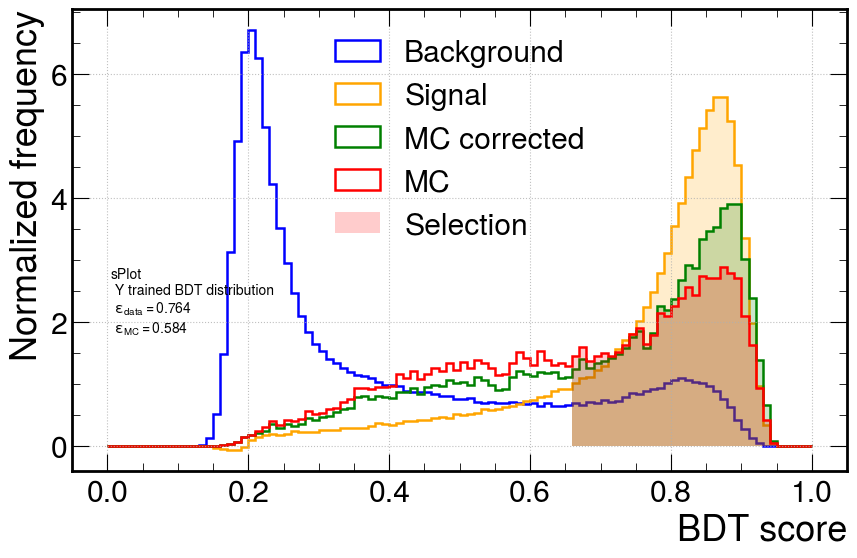

In [33]:
x = 0.5*(xe[:-1]+xe[1:])
# fine_x = np.linspace(x[0],x[-1],1000)
dx = np.diff(xe)[0]

bin_cut=np.digitize(cutYDataBdt, xe)

hep.style.use("CMS")
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(scoreYData, nbins, (0,1),  False, weights = fYData["bkgYield_sw"]/YdataTotalYield*nbins, label="Background", color = "blue", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreYData, nbins, (0,1),  False, weights = fYData["sigYield_sw"]/YdataTotalYield*nbins, label="Signal", color = "orange", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreYData, nbins, (0,1),  False, weights = fYData["sigYield_sw"]*(scoreYData>xe[bin_cut])/YdataTotalYield*nbins, color = "orange", zorder=0, histtype='bar', linewidth = 1.8, alpha = .2)

ax.hist(scoreYMC, nbins, (0,1),  False, weights =  0.5*(corrections+fYMC["sigYield_sw"]/YMCTotalYield)*nbins, label="MC corrected", color = "green", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreYMC, nbins, (0,1),  False, weights =  0.5*(corrections+fYMC["sigYield_sw"]/YMCTotalYield)*(scoreYMC>xe[bin_cut])*nbins,  color = "green", zorder=0, histtype='bar', linewidth = 1.8 , alpha=.2)

ax.hist(scoreYMC, nbins, (0,1),  False, weights =  fYMC["sigYield_sw"]/YMCTotalYield*nbins, label="MC", color = "red", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreYMC, nbins, (0,1),  False, weights =  fYMC["sigYield_sw"]*(scoreYMC>xe[bin_cut])/YMCTotalYield*nbins,  color = "red", label ='Selection', zorder=0, histtype='bar', linewidth = 1.8 , alpha=.2)
ax.text(0.05,0.3, f"sPlot\n Y trained BDT distribution \n $\epsilon_{{data}} = ${round(effYData,3)} \n $\epsilon_{{MC}} = ${round(effYMC_corr,3)}", fontsize = 10,  transform=ax.transAxes)
ax.grid()
ax.legend()    
ax.set_xlabel("BDT score")
ax.set_ylabel("Normalized frequency")

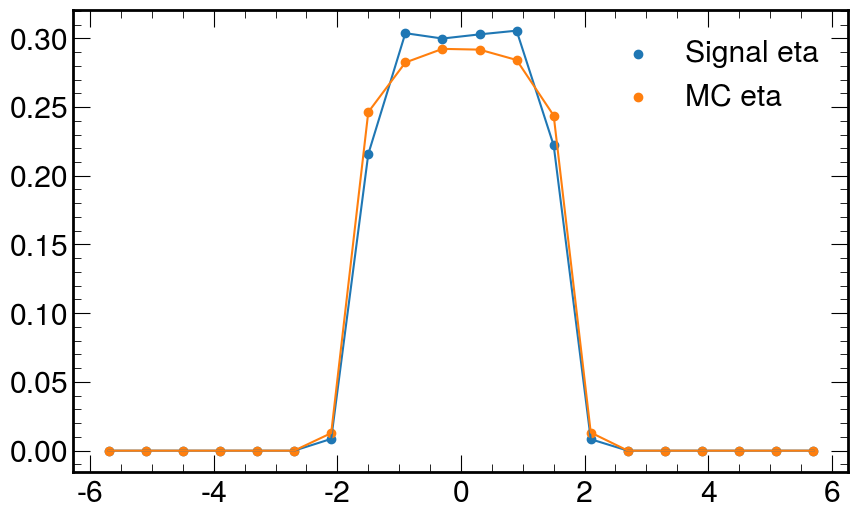

In [34]:
#Calculating eta corrections on the MC on Jpsi
#MC correction based on eta 
nbins_correction = 20
histSEta,_ = np.histogram(fJpsiData["Mm_kin_eta"],nbins_correction,weights=fJpsiData["sigYield_sw"], range=(-6,6),  density=True) #range=(-8.38,6.9),-
histMCEta,edges = np.histogram(fJpsiMC["Mm_kin_eta"],nbins_correction, weights = fJpsiMC["sigYield_sw"], range=(-6,6), density=True)
weight_hist = np.where(histMCEta == 0, 0, histSEta/histMCEta)  

hep.style.use("CMS")
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(0.5*(edges[:-1] + edges[1:]),histSEta, label = "Signal eta" )
ax.scatter(0.5*(edges[:-1] + edges[1:]),histMCEta, label = "MC eta")
ax.plot(0.5*(edges[:-1] + edges[1:]),histSEta,)
ax.plot(0.5*(edges[:-1] + edges[1:]),histMCEta,)
# ax.scatter(0.5*(edges[:-1] + edges[1:]),weight_hist,)
ax.legend()

corrections = weight_hist[np.digitize(fJpsiMC["Mm_kin_eta"], edges) - 1]
corrections = corrections/np.sum(corrections)

In [35]:
"""
A first study of the efficiency of the BDT on the Jpsi peak. Here look at the BDT trained on Y

"""

#These are the  s/sqrt(b) - optimized cuts. s and b discerned by simple mass cut 
###TODO update cuts
cutJDataId =  0.37
cutJDataBdt = 0.47

print(f"Study efficiency of cuts on Jpsi peak \nID cut: {cutJDataId}\nBDT cut: {cutJDataBdt}")

#The BDT results before the cut
scoreJpsiData = fJpsiData["forest_standard_Y_mva"]
scoreJpsiMC = fJpsiMC["forest_standard_Y_mva"]

#The total signal yields as for the sPlot weights before cuts
JpsiDataTotalYield = np.sum(fJpsiData["sigYield_sw"])
JpsiMCTotalYield = np.sum(fJpsiMC["sigYield_sw"])
print("Total data signal yield: ", JpsiDataTotalYield)
print("Total MC signal yield: ", JpsiMCTotalYield, "\n\n")

#compute corrected weights
corr_weights = 0.5*(corrections*JpsiMCTotalYield + fJpsiMC["sigYield_sw"])

nbins = 100
histJpsiB,_ = np.histogram(scoreJpsiData,nbins,(0,1),False,fJpsiData["bkgYield_sw"])
histJpsiS,xe = np.histogram(scoreJpsiData,nbins,(0,1),False,fJpsiData["sigYield_sw"])
histJpsiMC,_ = np.histogram(scoreJpsiMC,nbins,(0,1),False, fJpsiMC["sigYield_sw"])
histJpsiMC_corrected,_ = np.histogram(scoreJpsiMC,nbins,(0,1),False,corr_weights)

dx = xe[1]-xe[0]
x = 0.5*(xe[:-1]+xe[1:])

#The event cuts on the ID
dataCutOnIDJ = (fJpsiData["Muon_softMva1"] > cutJDataId) & (fJpsiData["Muon_softMva2"]> cutJDataId)  
MCCutOnIDJ = (fJpsiMC["Muon_softMva1"] > cutJDataId) & (fJpsiMC["Muon_softMva2"] > cutJDataId)     

print("Efficiency data ID cut: ", np.sum(fJpsiData["sigYield_sw"][dataCutOnIDJ])/JpsiDataTotalYield)
print("Efficiency MC ID cut: ", np.sum(fJpsiMC["sigYield_sw"][MCCutOnIDJ])/JpsiMCTotalYield, "\n\n")
print("Efficiency corrected MC ID cut: ", np.sum(corr_weights[MCCutOnIDJ])/JpsiMCTotalYield, "\n\n")

histJpsiB_IDcut,_ = np.histogram(scoreJpsiData[dataCutOnIDJ],nbins,(0,1),False,fJpsiData["bkgYield_sw"][dataCutOnIDJ])
histJpsiS_IDcut,_ = np.histogram(scoreJpsiData[dataCutOnIDJ],nbins,(0,1),False,fJpsiData["sigYield_sw"][dataCutOnIDJ])
histJpsiMC_IDcut,_ = np.histogram(scoreJpsiMC[MCCutOnIDJ],nbins,(0,1),False,fJpsiMC["sigYield_sw"][MCCutOnIDJ])
histJpsiMC_corr_IDcut,_ = np.histogram(scoreJpsiMC[MCCutOnIDJ],nbins,(0,1),False,corr_weights[MCCutOnIDJ])

print("check yields after ID cut:", np.sum(histJpsiS_IDcut), np.sum(histJpsiMC_IDcut), np.sum(histJpsiMC_corr_IDcut), "\n")

JpsidataYield = np.sum(histJpsiS_IDcut*(x>cutJDataBdt) )
JpsiMCYield = np.sum(histJpsiMC_IDcut*(x>cutJDataBdt) )
JpsiMC_corr_Yield = np.sum(histJpsiMC_corr_IDcut*(x>cutJDataBdt) )

print("dataYield " , JpsidataYield)
print("MCYield " , JpsiMCYield, "\n\n")
print("MC corr Yield " , JpsiMC_corr_Yield, "\n\n")

effJpsiData =  JpsidataYield/JpsiDataTotalYield
effJpsiMC = JpsiMCYield/JpsiMCTotalYield
effJpsiMC_corr = JpsiMC_corr_Yield/JpsiMCTotalYield

print("BDT efficiency on Y peak: \n On data: ",effJpsiData, "\n On MC: ", effJpsiMC, "\n On corrected MC: ", effJpsiMC_corr)
print("Efficiency difference: " , (effJpsiMC_corr - effJpsiData))



Study efficiency of cuts on Jpsi peak 
ID cut: 0.37
BDT cut: 0.47
Total data signal yield:  678705.5394828203
Total MC signal yield:  92067.67950892271 


Efficiency data ID cut:  0.9456685215813496
Efficiency MC ID cut:  0.9298160381972451 


Efficiency corrected MC ID cut:  0.9303089232085533 


check yields after ID cut: 641830.4641117856 85606.00500700054 85651.38378625704 

dataYield  345155.8764684656
MCYield  45174.53472611047 


MC corr Yield  45210.625970099834 


BDT efficiency on Y peak: 
 On data:  0.5085502569074026 
 On MC:  0.49066659404327 
 On corrected MC:  0.4910586017943274
Efficiency difference:  -0.01749165511307521


Text(0, 1, 'Normalized frequency')

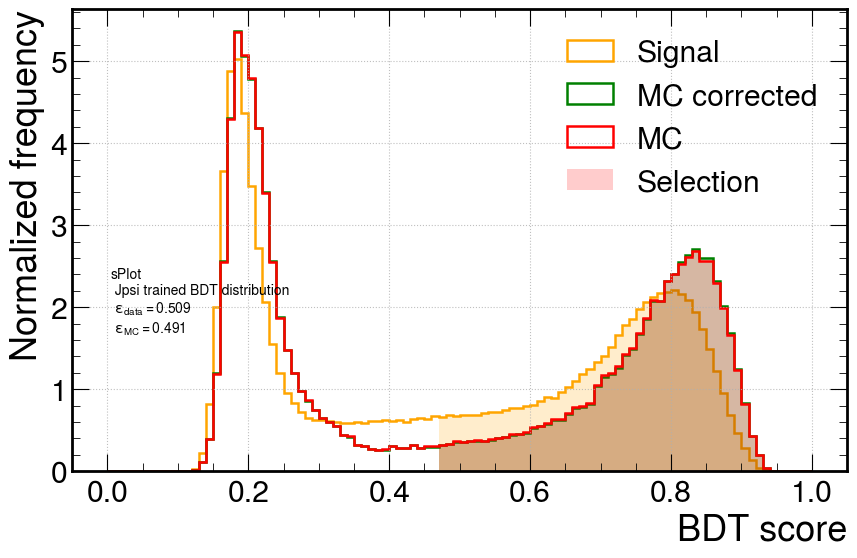

In [36]:
x = 0.5*(xe[:-1]+xe[1:])
# fine_x = np.linspace(x[0],x[-1],1000)
dx = np.diff(xe)[0]

bin_cut=np.digitize(cutJDataBdt, xe)

hep.style.use("CMS")
fig, ax = plt.subplots(figsize=(10,6))
# ax.hist(scoreJpsiData, nbins, (0,1),  False, weights = fJpsiData["bkgYield_sw"]/JpsidataTotalYield*nbins, label="Background", color = "blue", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreJpsiData, nbins, (0,1),  False, weights = fJpsiData["sigYield_sw"]/JpsiDataTotalYield*nbins, label="Signal", color = "orange", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreJpsiData, nbins, (0,1),  False, weights = fJpsiData["sigYield_sw"]*(scoreJpsiData>xe[bin_cut])/JpsiDataTotalYield*nbins, color = "orange", zorder=0, histtype='bar', linewidth = 1.8, alpha = .2)

ax.hist(scoreJpsiMC, nbins, (0,1),  False, weights =  0.5*(corrections+fJpsiMC["sigYield_sw"]/JpsiMCTotalYield)*nbins, label="MC corrected", color = "green", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreJpsiMC, nbins, (0,1),  False, weights =  0.5*(corrections+fJpsiMC["sigYield_sw"]/JpsiMCTotalYield)*(scoreJpsiMC>xe[bin_cut])*nbins,  color = "green", zorder=0, histtype='bar', linewidth = 1.8 , alpha=.2)

ax.hist(scoreJpsiMC, nbins, (0,1),  False, weights =  fJpsiMC["sigYield_sw"]/JpsiMCTotalYield*nbins, label="MC", color = "red", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreJpsiMC, nbins, (0,1),  False, weights =  fJpsiMC["sigYield_sw"]*(scoreJpsiMC>xe[bin_cut])/JpsiMCTotalYield*nbins,  color = "red", label ='Selection', zorder=0, histtype='bar', linewidth = 1.8 , alpha=.2)
ax.text(0.05,0.3, f"sPlot\n Jpsi trained BDT distribution \n $\epsilon_{{data}} = ${round(effJpsiData,3)} \n $\epsilon_{{MC}} = ${round(effJpsiMC_corr,3)}", fontsize = 10,  transform=ax.transAxes)
ax.grid()
ax.legend()    
ax.set_xlabel("BDT score")
ax.set_ylabel("Normalized frequency")

1792.4673925751379 0.1702800829876624
796135.2899689623 630487


Text(0, 1, 'Frequency')

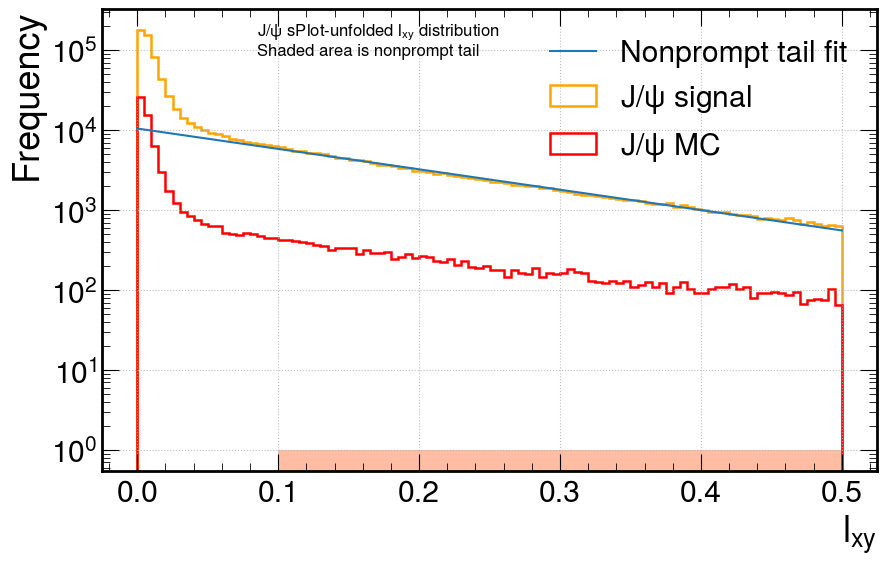

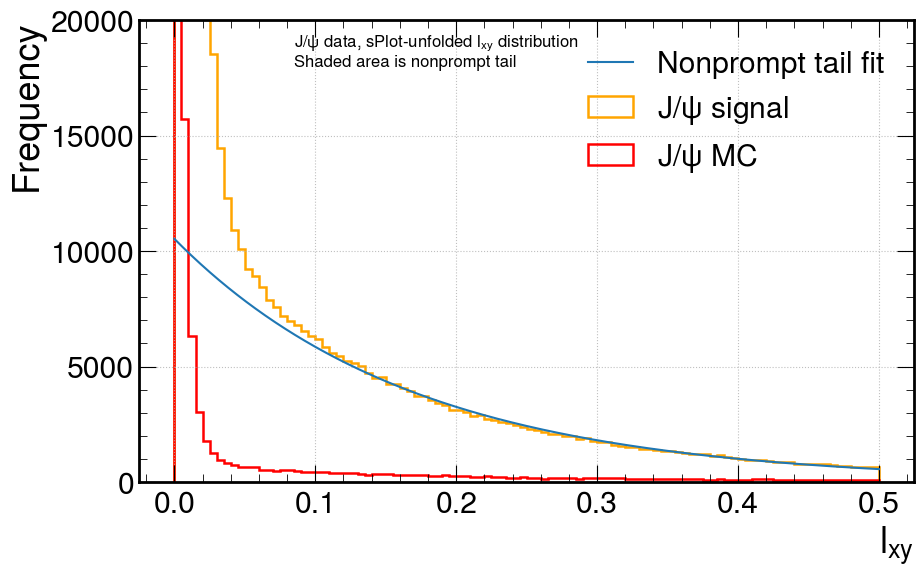

In [39]:
"""
Look at lxy distribution; fit nonprompt tail with exp + const and extrapolate corrections to prompt part
"""
lxy_range=(0,0.5)
mask_range = 0.1, lxy_range[1]
dx = (lxy_range[1]-lxy_range[0])/nbins

def nonPrompt_tail(x,N,b):
   return  N*expon.pdf(x,0,b)

##Failed attempt with ExtendedUNLL
# costMethod = ExtendedUnbinnedNLL
# cf_data = costMethod(ak.to_numpy(fJpsiData["Mm_kin_lxy"]),nonPrompt_tail)
# cf_data.mask = (fJpsiData["Mm_kin_lxy"] > mask_range[0]) & (fJpsiData["Mm_kin_lxy"] < mask_range[1])

costMethod = LeastSquares
n,xe = np.histogram(ak.to_numpy(fJpsiData["Mm_kin_lxy"]), nbins, lxy_range) # weights = ak.to_numpy(fJpsiData["sigYield_sw"]))
x = 0.5*(xe[1:] + xe[:-1])
dx = xe[1]-xe[0]
mask = (x > mask_range[0]) & (x < mask_range[1])
cf_data = costMethod(x[mask],n[mask], n[mask]**0.5, nonPrompt_tail)

ivData = [len(fJpsiData["Mm_kin_lxy"]),  0.4]
mData = Minuit(cf_data,*ivData)

mData.limits = [(0,len(fJpsiData["Mm_kin_lxy"])), (0,1)]
mData.migrad()
mData.hesse() 
print(*mData.values)

# p = np.polyfit(x[mask],np.log(n[mask]),1)

fig, ax = plt.subplots(figsize=(10,6))
# ax.hist(fJpsiData["Mm_kin_lxy"], nbins)
x = np.linspace(*lxy_range, 1000)
ax.plot(x,nonPrompt_tail(x,*mData.values), label = "Nonprompt tail fit")
# ax.plot(x,np.exp(np.polyval(p, x))/JpsiDataTotalYield*nbins, label = "Nonprompt tail fit 2")

ax.hist(fJpsiData["Mm_kin_lxy"], nbins, lxy_range,  False,  label="$J/\psi$ signal", color = "orange", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(fJpsiData["Mm_kin_lxy"], nbins, lxy_range,  False, weights=(fJpsiData["Mm_kin_lxy"]>mask_range[0]), color = "orange", zorder=0, histtype='bar', linewidth = 1.8, alpha = .2)
ax.hist(fJpsiMC["Mm_kin_lxy"], nbins, lxy_range,  False,  label="$J/\psi$ MC", color = "red", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(fJpsiMC["Mm_kin_lxy"], nbins, lxy_range,  False, weights=(fJpsiMC["Mm_kin_lxy"]>mask_range[0]),  color = "red", zorder=0, histtype='bar', linewidth = 1.8 , alpha=.2)
# ax.hist(fYData["Mm_kin_lxy"], nbins, lxy_range,  True, weights = fYData["sigYield_sw"], label="Y signal", color = "blue", zorder=0, histtype='step', linewidth = 1.8)
ax.text(0.2,0.9, f"J/$\psi$ sPlot-unfolded $l_{{xy}}$ distribution \nShaded area is nonprompt tail", fontsize = 12, transform=ax.transAxes)
ax.grid()
ax.legend()    
ax.set_xlabel("$l_{xy}$")
# ax.set_ylim(0,20000)
ax.set_ylabel("Frequency")
plt.yscale('log')

import scipy
Nonprompt_in_prompt,_ = scipy.integrate.quad(lambda x: nonPrompt_tail(x,*mData.values), 0, mask_range[0])
print(Nonprompt_in_prompt*1000,np.sum(fJpsiData["Mm_kin_lxy"] < mask_range[0]))

# histS,edges = np.histogram(sigJ[(sigJ["Mm_mass"]>mjpsi-window) & (sigJ["Mm_mass"]<mjpsi+window)]["Mm_kin_eta"],20, range=(-2.3,2.3),density=True)
# histMC,_ = np.histogram(dataMCJ["Mm_kin_eta"],20, range=(-2.3,2.3),density=True)
# weight_hist = histS/histMC
# corrections = weight_hist[np.digitize(dataMCJ["Mm_kin_eta"], edges) - 1]
# pred_MCJ = dataMCJ["vtx_BDT_forest"]

fig, ax = plt.subplots(figsize=(10,6))
x = np.linspace(*lxy_range, 1000)
ax.plot(x,nonPrompt_tail(x,*mData.values), label = "Nonprompt tail fit")
ax.hist(fJpsiData["Mm_kin_lxy"], nbins, lxy_range,  False,  label="$J/\psi$ signal", color = "orange", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(fJpsiData["Mm_kin_lxy"], nbins, lxy_range,  False, weights = (fJpsiData["Mm_kin_lxy"]>mask_range[0]), color = "orange", zorder=0, histtype='bar', linewidth = 1.8, alpha = .2)
ax.hist(fJpsiMC["Mm_kin_lxy"], nbins, lxy_range,  False,  label="$J/\psi$ MC", color = "red", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(fJpsiMC["Mm_kin_lxy"], nbins, lxy_range,  False, weights = fJpsiMC["Mm_kin_lxy"]>mask_range[0],  color = "red", zorder=0, histtype='bar', linewidth = 1.8 , alpha=.2)
ax.text(0.2,0.9, f"J/$\psi$ data, sPlot-unfolded $l_{{xy}}$ distribution \nShaded area is nonprompt tail", fontsize = 12, transform=ax.transAxes)
ax.grid()
ax.legend()    
# ax.set_xlim(0,0.2)
ax.set_ylim(0,1e5)
ax.set_xlabel("$l_{xy}$")
ax.set_ylim(0,20000)
ax.set_ylabel("Frequency")

efficiency of lxy cut:  0.9642017230350718
Start fitting function  <function nonPrompt_tail at 0x7f2bd55d8e00> to variable  Mm_kin_lxy
Done fitting. Parameters:  1792.461198418442 0.17027914653914042
[0.942, 0.936, 0.881, 0.783, 0.653, ..., 0.102, 0.0734, 0.0593, 0.114, 0.0989] 39 -0.06602039291158661 7.402721153774653
[0.21, 0.881, 0.936, 0.942, 0.881, ..., 0.398, 0.0699, 0.936, 0.102, 0.936] 471507.75854526076 471489.5807570774


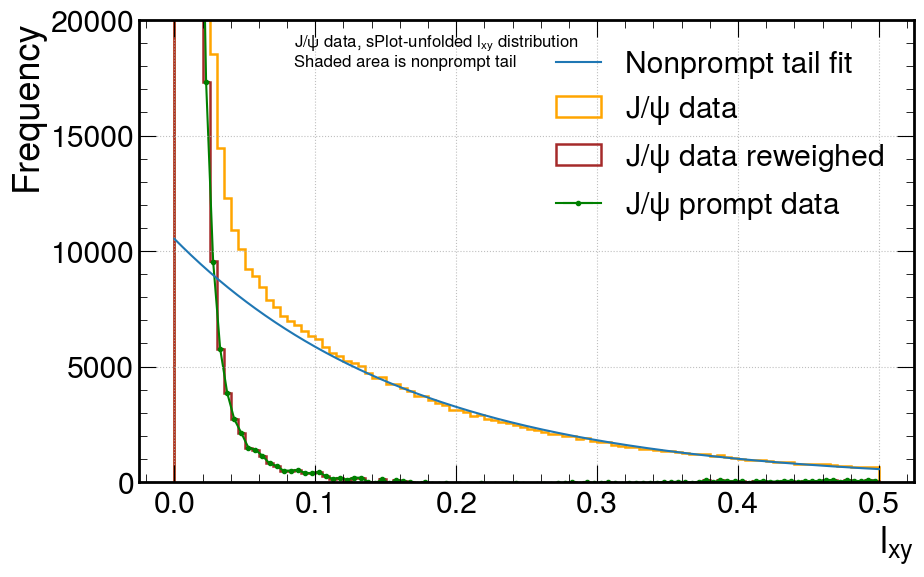

In [38]:

lxy_cutoff = 0.5
fJpsiDataPrompt = fJpsiData[fJpsiData["Mm_kin_lxy"] < lxy_cutoff]
print("efficiency of lxy cut: ", len(fJpsiDataPrompt)/len(fJpsiData))


t = Trainer('Jpsi')
weights_computed = t.compute_reweight(fJpsiDataPrompt,'Mm_kin_lxy',nonPrompt_tail, nbins_fit=100,nbins_corrections=100,fit_range=(0.1,0.5), fitting_limits=[(0,0.2)])


nbins_correction = 100
histSlxy,xe = np.histogram(fJpsiDataPrompt["Mm_kin_lxy"],nbins_correction)#,weights=fJpsiDataPrompt["sigYield_sw"]) 
dxp = xe[1]-xe[0]
weight_hist = (histSlxy-nonPrompt_tail(0.5*(xe[:-1] + xe[1:]),*mData.values)/dx*dxp)/histSlxy
print(weight_hist, np.argmin(weight_hist), min(weight_hist), np.sum(weight_hist))
# weight_hist_normed = weight_hist/np.sum(histSlxy)
# plt.plot(xe[:-1], weight_hist_normed, color = 'red')
corrections = weight_hist[np.digitize(fJpsiDataPrompt["Mm_kin_lxy"], xe, right=True) - 1]
# corrections = np.sum(histSlxy-nonPrompt_tail(0.5*(xe[:-1] + xe[1:]),*mData.values)/dx*dxp)*corrections/np.sum(corrections)

fig, ax = plt.subplots(figsize=(10,6))
x = np.linspace(0,lxy_cutoff, 1000)
ax.plot(x,nonPrompt_tail(x,*mData.values)/dx*dxp, label = "Nonprompt tail fit")
ax.errorbar(0.5*(xe[:-1] + xe[1:]),histSlxy-nonPrompt_tail(0.5*(xe[:-1] + xe[1:]),*mData.values)/dx*dxp,xerr = dxp/2, label="$J/\psi$ prompt data", color = "green", zorder=0,marker = '.')
ax.hist(fJpsiDataPrompt["Mm_kin_lxy"], nbins_correction, (0,lxy_cutoff),  False,  label="$J/\psi$ data", color = "orange", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(fJpsiDataPrompt["Mm_kin_lxy"], nbins_correction, (0,lxy_cutoff),  False, weights=weights_computed, label="$J/\psi$ data reweighed", color = "brown", zorder=0, histtype='step', linewidth = 1.8)
# ax.hist(fJpsiDataPrompt["Mm_kin_lxy"], nbins_correction, (0,lxy_cutoff),  False, weights=corrections, label="$J/\psi$ data reweighed 1", color = "red", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(fJpsiDataPrompt["Mm_kin_lxy"], nbins_correction, (0,lxy_cutoff),  False, weights = (fJpsiDataPrompt["Mm_kin_lxy"]>mask_range[0]), color = "purple", zorder=0, histtype='bar', linewidth = 1.8, alpha = .2)
ax.text(0.2,0.9, f"J/$\psi$ data, sPlot-unfolded $l_{{xy}}$ distribution \nShaded area is nonprompt tail", fontsize = 12, transform=ax.transAxes)
ax.grid()
ax.legend()    
# ax.set_xlim(0,0.2)
# ax.set_ylim(0,1e4)
ax.set_xlabel("$l_{xy}$")
ax.set_ylim(0,20000)
ax.set_ylabel("Frequency")


import scipy
Nonprompt_in_prompt,_ = scipy.integrate.quad(lambda x: nonPrompt_tail(x,*mData.values)/dxp, 0, lxy_cutoff)
prompt = np.sum(histSlxy) - Nonprompt_in_prompt
print(corrections,np.sum(corrections),prompt)




In [25]:
"""
A first study of the efficiency of the BDT on the Jpsi peak. Here look at the BDT trained on Y

"""
#These are the  s/sqrt(b) - optimized cuts. s and b discerned by simple mass cut 
cutJDataId =  0.37
cutJDataBdt = 0.47

print(f"Study efficiency of cuts on Jpsi peak \nID cut: {cutJDataId}\nBDT cut: {cutJDataBdt}")

#The BDT results before the cut
scoreJpsiDataPrompt = fJpsiDataPrompt["forest_standard_Y_mva"]
scoreJpsiMC = fJpsiMC["forest_standard_Y_mva"]

#The total signal yields as for the sPlot weights before cuts
JpsiDataPromptTotalYield = np.sum(fJpsiDataPrompt["sigYield_sw"])
JpsiMCTotalYield = np.sum(fJpsiMC["sigYield_sw"])
print("Total dataPrompt signal yield: ", JpsiDataPromptTotalYield)
print("Total MC signal yield: ", JpsiMCTotalYield, "\n\n")

#compute corrected weights
# corr_weights = 0.5*(corrections*JpsiDataPromptTotalYield + fJpsiDataPrompt["sigYield_sw"])
corr_weights = JpsiDataPromptTotalYield*(corrections*fJpsiDataPrompt["sigYield_sw"]/np.sum(fJpsiDataPrompt["sigYield_sw"]))/np.sum((corrections*fJpsiDataPrompt["sigYield_sw"]/np.sum(fJpsiDataPrompt["sigYield_sw"])))
print(JpsiDataPromptTotalYield/np.sum(corr_weights))

nbins = 100
histJpsiB,_ = np.histogram(scoreJpsiDataPrompt,nbins,(0,1),False,fJpsiDataPrompt["bkgYield_sw"])
histJpsiS,xe = np.histogram(scoreJpsiDataPrompt,nbins,(0,1),False,fJpsiDataPrompt["sigYield_sw"])
histJpsiS_corrected,_ = np.histogram(scoreJpsiDataPrompt,nbins,(0,1),False,corr_weights)
histJpsiMC,_ = np.histogram(scoreJpsiMC,nbins,(0,1),False, fJpsiMC["sigYield_sw"])

dx = xe[1]-xe[0]
x = 0.5*(xe[:-1]+xe[1:])

#The event cuts on the ID
dataCutOnIDJ = (fJpsiDataPrompt["Muon_softMva1"] > cutJDataId) & (fJpsiDataPrompt["Muon_softMva2"]> cutJDataId)  
MCCutOnIDJ = (fJpsiMC["Muon_softMva1"] > cutJDataId) & (fJpsiMC["Muon_softMva2"] > cutJDataId)     
# print(np.sum(dataCutOnIDJ)/len(dataCutOnIDJ))

print("Efficiency data ID cut: ", np.sum(fJpsiDataPrompt["sigYield_sw"][dataCutOnIDJ])/JpsiDataPromptTotalYield)
print("Efficiency corrected data ID cut: ", np.sum(corr_weights[dataCutOnIDJ])/JpsiDataPromptTotalYield)
print("Efficiency MC ID cut: ", np.sum(fJpsiMC["sigYield_sw"][MCCutOnIDJ])/JpsiMCTotalYield, "\n\n")

histJpsiB_IDcut,_ = np.histogram(scoreJpsiDataPrompt[dataCutOnIDJ],nbins,(0,1),False,fJpsiDataPrompt["bkgYield_sw"][dataCutOnIDJ])
histJpsiS_IDcut,_ = np.histogram(scoreJpsiDataPrompt[dataCutOnIDJ],nbins,(0,1),False,fJpsiDataPrompt["sigYield_sw"][dataCutOnIDJ])
histJpsiS_corr_IDcut,_ = np.histogram(scoreJpsiDataPrompt[dataCutOnIDJ],nbins,(0,1),False,corr_weights[dataCutOnIDJ])
histJpsiMC_IDcut,_ = np.histogram(scoreJpsiMC[MCCutOnIDJ],nbins,(0,1),False,fJpsiMC["sigYield_sw"][MCCutOnIDJ])

print("check yields after ID cut:", np.sum(histJpsiS_IDcut), np.sum(histJpsiS_corr_IDcut) ,np.sum(histJpsiMC_IDcut), "\n")

JpsidataYield = np.sum(histJpsiS_IDcut*(x>cutJDataBdt) )
JpsiS_corr_Yield = np.sum(histJpsiS_corr_IDcut*(x>cutJDataBdt) )
JpsiMCYield = np.sum(histJpsiMC_IDcut*(x>cutJDataBdt) )

print("dataYield " , JpsidataYield)
print("data prompt corr Yield " , JpsiS_corr_Yield)
print("MCYield " , JpsiMCYield, "\n\n")

effJpsiDataPrompt =  JpsidataYield/JpsiDataPromptTotalYield
effJpsiDataPrompt_corr = JpsiS_corr_Yield/JpsiDataPromptTotalYield
effJpsiMC = JpsiMCYield/JpsiMCTotalYield

print("BDT efficiency on Y peak: \n On prompt data: ",  effJpsiDataPrompt, "\n On corrected prompt data: ", effJpsiDataPrompt_corr, "\n On MC: ", effJpsiMC)
print("Efficiency difference: " , (effJpsiDataPrompt_corr - effJpsiDataPrompt))



Study efficiency of cuts on Jpsi peak 
ID cut: 0.37
BDT cut: 0.47
Total dataPrompt signal yield:  659403.1619668993
Total MC signal yield:  92067.67950892271 


0.9999999999999905
Efficiency data ID cut:  0.9458956259051815
Efficiency corrected data ID cut:  0.9456916463307525
Efficiency MC ID cut:  0.9298160381972451 


check yields after ID cut: 623726.5666125368 623592.0618361617 85606.00500700054 

dataYield  345150.507645892
data prompt corr Yield  492770.3278247834
MCYield  45174.53472611047 


BDT efficiency on Y peak: 
 On prompt data:  0.5234286511704926 
 On corrected prompt data:  0.7472974899831 
 On MC:  0.49066659404327
Efficiency difference:  0.22386883881260733


Text(0, 1, 'Normalized frequency')

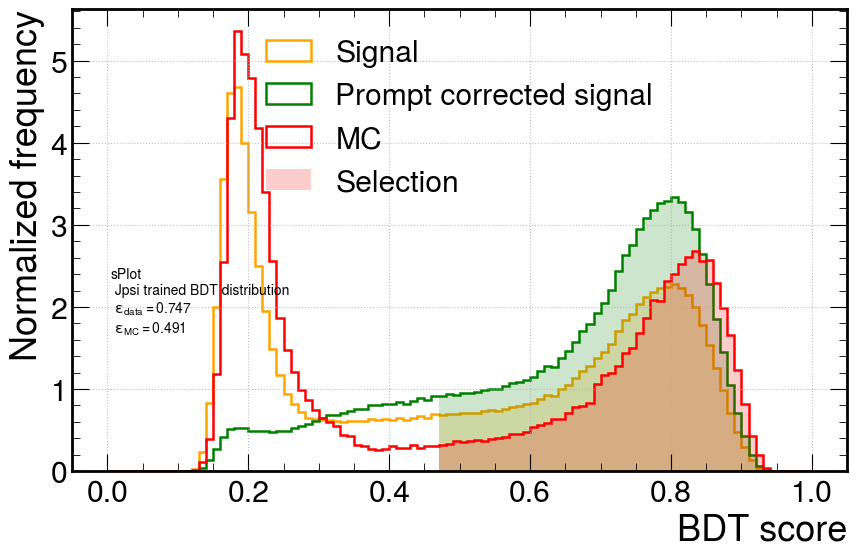

In [26]:
x = 0.5*(xe[:-1]+xe[1:])
# fine_x = np.linspace(x[0],x[-1],1000)
dx = np.diff(xe)[0]

bin_cut=np.digitize(cutJDataBdt, xe)

hep.style.use("CMS")
fig, ax = plt.subplots(figsize=(10,6))
# ax.hist(scoreJpsiDataPrompt, nbins, (0,1),  False, weights = fJpsiDataPromptPrompt["bkgYield_sw"]/JpsidataPromptTotalYield*nbins, label="Background", color = "blue", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreJpsiDataPrompt, nbins, (0,1),  False, weights = fJpsiDataPrompt["sigYield_sw"]/JpsiDataPromptTotalYield*nbins, label="Signal", color = "orange", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreJpsiDataPrompt, nbins, (0,1),  False, weights = fJpsiDataPrompt["sigYield_sw"]*(scoreJpsiDataPrompt>xe[bin_cut])/JpsiDataPromptTotalYield*nbins, color = "orange", zorder=0, histtype='bar', linewidth = 1.8, alpha = .2)

ax.hist(scoreJpsiDataPrompt, nbins, (0,1),  False, weights =  corr_weights/JpsiDataPromptTotalYield*nbins, label="Prompt corrected signal", color = "green", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreJpsiDataPrompt, nbins, (0,1),  False, weights =  corr_weights/JpsiDataPromptTotalYield*(scoreJpsiDataPrompt>xe[bin_cut])*nbins,  color = "green", zorder=0, histtype='bar', linewidth = 1.8 , alpha=.2)

ax.hist(scoreJpsiMC, nbins, (0,1),  False, weights =  fJpsiMC["sigYield_sw"]/JpsiMCTotalYield*nbins, label="MC", color = "red", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreJpsiMC, nbins, (0,1),  False, weights =  fJpsiMC["sigYield_sw"]*(scoreJpsiMC>xe[bin_cut])/JpsiMCTotalYield*nbins,  color = "red", label ='Selection', zorder=0, histtype='bar', linewidth = 1.8 , alpha=.2)
ax.text(0.05,0.3, f"sPlot\n Jpsi trained BDT distribution \n $\epsilon_{{data}} = ${round(effJpsiDataPrompt_corr,3)} \n $\epsilon_{{MC}} = ${round(effJpsiMC,3)}", fontsize = 10,  transform=ax.transAxes)
ax.grid()
ax.legend()    
ax.set_xlabel("BDT score")
ax.set_ylabel("Normalized frequency")

In [27]:
particle_config = config["BDT_training"]["Jpsi"]
hyperpars = particle_config["models"]["forest_standard"]["hyperpars"]
train_vars = particle_config["models"]["forest_standard"]["train_vars"] 
random_seed = particle_config["models"]["forest_standard"]["random_seed"]

sig_lims = particle_config["limits"]["signal"] 
bkg_lims = particle_config["limits"]["background"]

#for loop over pair of extremals of signal/bkg regions, to keep as general as possible in case of multiple signal/bkg intervals
mass = fJpsiDataPrompt["Mm_mass"]
sig_cut = (mass < -1e3)
for lims in sig_lims:
    sig_cut = sig_cut | ((mass>lims[0])&(mass<lims[1]))

bkg_cut = (mass < -1e3)
for lims in bkg_lims:
    bkg_cut = bkg_cut | ((mass>lims[0])&(mass<lims[1]))

sig = pd.DataFrame(ak.to_dataframe(fJpsiDataPrompt[sig_cut]))
bkg = pd.DataFrame(ak.to_dataframe(fJpsiDataPrompt[bkg_cut]))
sig['Score'] = 1
bkg['Score'] = 0
sig_frac = -1 if (len(sig)+len(bkg)) == 0 else len(sig)/(len(sig)+len(bkg))

trainData = pd.concat([sig,bkg])
trainData_skinny = trainData[train_vars]
X_temp, X_test, y_temp, y_test = train_test_split(trainData_skinny, trainData["Score"], test_size=0.1, shuffle=True, random_state=random_seed)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, shuffle=True, random_state=random_seed)

corrections_positive = np.where(corrections<0,0,corrections)
# print(corrections_positive[(X_train.index)])
dtrain = xgb.DMatrix(X_train, label=y_train, weight = corrections_positive[X_train.index])
dval = xgb.DMatrix(X_val, label=y_val, weight = corrections_positive[X_val.index])
print(f"Defined training and evaluation datasets\nTrain on {len(X_train)} events, of which a fraction {sig_frac} is signal, and {len(train_vars)} variables")

# num_round = particle_config["models"]["forest_standard"]["num_rounds"]
# evallist = [(dtrain, 'train'), (dval, 'eval')]
# bst = xgb.train(hyperpars, dtrain, num_round, evals=evallist)
# bst.save_model(os.path.join("/work/submit/mori25/Darkphotons_ludo/BDT/trained_models", "forest_standard"+"_"+"Jpsi_prompt"+".json"))
# print("Training successful, model saved to file " + os.path.join("/work/submit/mori25/Darkphotons_ludo/BDT/trained_models", "forest_standard"+"_"+"Jpsi_prompt"+".json"))

KeyError: 'forest_standard'

In [ ]:
def plot_hist(data,names,nbins=100,xlabel = None, saveas=None, text = None, xlim=None, log = False, density=False, int_xticks = False):
    hep.style.use("CMS")
    colors = plt.cm.tab10.colors
    fig, ax = plt.subplots(figsize=(12,9))
    hep.cms.text("Preliminary")
    for d,name,c in zip(data,names,colors[:len(data)]):
        ax.hist(d, bins = nbins, range = xlim, label=name, color=c, density = density, log=log, histtype='step', linewidth=2)
        # ax.hist(d, bins = nbins, range = xlim, color=c, density = density, log=log, alpha = 0.5)# hatch = '*',
    if (xlabel): ax.set_xlabel(xlabel)
    if text!=None: ax.text(0.02, .8, text, fontsize=11, bbox=dict(facecolor='white', edgecolor='black'), transform=ax.transAxes) 
    if int_xticks: ax.xaxis.get_major_locator().set_params(integer=True)
    ax.set_ylabel('Normalized frequency')
    ax.set_xlim(xlim)
    ax.legend()
    ax.grid(True)
    if saveas: plt.savefig(saveas)
    return


val_bkg=bst.predict(xgb.DMatrix(X_val[y_val==0]))
val_sig=bst.predict(xgb.DMatrix(X_val[y_val==1]))
train_bkg=bst.predict(xgb.DMatrix(X_train[y_train==0]))
train_sig=bst.predict(xgb.DMatrix(X_train[y_train==1]))
plot_hist([val_bkg,val_sig,train_bkg,train_sig],["Bkg.","Sig.","Training bkg.","Train sig."],nbins =100, density=True, xlabel="BDT score")

NameError: name 'bst' is not defined

Look into efficiency of extrapolated prompt events

Now do the same for the Y peak 

In [ ]:
#These are the  s/sqrt(b) - optimized cuts. s and b discerned by simple mass cut 
cutYDataId =0.396
cutYDataBdt = 0.5#0.797

print(f"Study efficiency of cuts on Upsilon peak \nID cut: {cutYDataId}\nBDT cut: {cutYDataBdt}")

#Select only signal around Y1. from now on only use fY1!!!  
Y1_cut =   (fYData["Mm_mass"] > 9.2) & (fYData["Mm_mass"] < 9.7) #fYData["Mm_mass"] >0 # 
fY1Data = fYData[Y1_cut]

#The BDT results before the cut
scoreY1Data = fY1Data["vtx_BDT_forest"]
scoreYMC = fYMC["vtx_BDT_forest"]

nbins = 100
histY1B,_ = np.histogram(scoreY1Data,nbins,(0,1),False,fY1Data["bkgYield_sw"])
histY1S,xe = np.histogram(scoreY1Data,nbins,(0,1),False,fY1Data["sigYield_sw"])
histYMC,_ = np.histogram(scoreYMC,nbins,(0,1),False,fYMC["sigYield_sw"])

dx = xe[1]-xe[0]
x = 0.5*(xe[:-1]+xe[1:])

#The total signal yields as for the sPlot weights before cuts
dataTotalYield = np.sum(fY1Data["sigYield_sw"])
MCTotalYield = np.sum(fYMC["sigYield_sw"])
bkgTotalYield = np.sum(fY1Data["bkgYield_sw"])

print("Total data signal yield: ", dataTotalYield)
print("Total MC signal yield: ", MCTotalYield)
print("Total data bkg yield: ", bkgTotalYield, "\n\n")

#The event cuts on the ID
dataCutOnIDY = (fY1Data["Muon_softMva1"] > cutYDataId) & (fY1Data["Muon_softMva2"]> cutYDataId)  
MCCutOnIDY = (fYMC["Muon_softMva1"] > cutYDataId) & (fYMC["Muon_softMva2"] > cutYDataId)     

print("Efficiency data ID cut: ", np.sum(fY1Data["sigYield_sw"][dataCutOnIDY])/dataTotalYield) 
print("Efficiency MC ID cut: ", np.sum(fYMC["sigYield_sw"][MCCutOnIDY])/MCTotalYield, "\n\n")


histY1B_IDcut,_ = np.histogram(scoreY1Data[dataCutOnIDY],nbins,(0,1),False,fY1Data["bkgYield_sw"][dataCutOnIDY])
histY1S_IDcut,_ = np.histogram(scoreY1Data[dataCutOnIDY],nbins,(0,1),False,fY1Data["sigYield_sw"][dataCutOnIDY])
histYMC_IDcut,_ = np.histogram(scoreYMC[MCCutOnIDY],nbins,(0,1),False,fYMC["sigYield_sw"][MCCutOnIDY])
histYMC_IDcut_corr, _  = np.histogram(scoreYMC[MCCutOnIDY],nbins,(0,1),False, 0.5*((fYMC["sigYield_sw"] ) + corrections*MCTotalYield)[MCCutOnIDY])


print("check yields after ID cut:", np.sum(histY1S_IDcut), np.sum(histYMC_IDcut), "\n")

dataY1ield = np.sum( histY1S_IDcut*(x>cutYDataBdt) )
MCYield = np.sum( histYMC_IDcut*(x>cutYDataBdt) )
MCYield_corr = np.sum( histYMC_IDcut_corr*(x>cutYDataBdt) )

print("Yields after BDT ID cuts:")
print("dataYield " , dataY1ield)
print("MCYield " , MCYield, "\n\n")

effData =  dataY1ield/dataTotalYield
effMC = MCYield/MCTotalYield
effMC_corr = MCYield_corr/MCTotalYield

print("BDT efficiency on Y peak: \n On data: ",effData, "\n On MC: ", effMC, "\n On corrected MC: ", effMC_corr)
print("Relative efficiency difference: " , (effMC_corr - effData))

In [ ]:
x = 0.5*(xe[:-1]+xe[1:])
# fine_x = np.linspace(x[0],x[-1],1000)
dx = np.diff(xe)[0]

bin_cut = np.digitize(cutYDataBdt, xe)

hep.style.use("CMS")
fig, ax = plt.subplots(figsize=(10,6))
# ax.hist(scoreYData,nbins,(0,1),True,fYData["bkgYield_sw"], label="Background", color = "blue", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreY1Data,nbins,(0,1),False,fY1Data["sigYield_sw"]/dataTotalYield*nbins, label="Signal", color = "orange", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreY1Data,nbins,(0,1),False,fY1Data["sigYield_sw"]*(scoreY1Data>xe[bin_cut])/dataTotalYield*nbins, color = "orange", zorder=0, histtype='bar', alpha = 0.2)

ax.hist(scoreYMC,nbins,(0,1),False,(fYMC["sigYield_sw"] )/(MCTotalYield/nbins) , label="MC", color = "red", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreYMC,nbins,(0,1),False,fYMC["sigYield_sw"]*(scoreYMC>xe[bin_cut])/MCTotalYield*nbins,  color = "red", zorder=0, histtype='bar', linewidth = 1.8,alpha=0.2)

ax.hist(scoreYMC,nbins,(0,1),False, nbins*((fYMC["sigYield_sw"] )/(MCTotalYield) + corrections) / 2 , label="$\eta$-corrected MC", color = "purple", zorder=0, histtype='step', linewidth = 1.8)
# ax.hist(scoreYMC,nbins,(0,1),False,nbins*(fYMC["sigYield_sw"]/MCTotalYield + corrections)/2*(scoreYMC>xe[bin_cut]),  color = "purple", zorder=0, histtype='bar', linewidth = 1.8,alpha=0.2)

ax.text(0.,1, f"Y sPlot-unfolded BDT distribution \nUsing signal from Y(1) peak\n$\epsilon_{{data}} = ${round(effData,3)} \n $\epsilon_{{MC}} = ${round(effMC,3)}\n$\epsilon_{{MC}}^{{corr}} = ${round(effMC_corr,3)}", fontsize = 10)

ax.grid()
ax.legend()    
ax.set_xlabel("BDT score")
ax.set_ylabel("Normalized frequency")

# print(xe[histYB<0],histYB[histYB<0])


In [ ]:
print(np.sum(corrections))

In this section will plot the fits 

In [ ]:
def parse_text_file(filename):
    # Initialize an empty dictionary to store the results
    result_dict = {}
    
    try:
        with open(filename, 'r') as file:
            lines = file.readlines()
            
            name = ""
            i=0

            for line in lines:
                i+=1
                # Remove leading and trailing whitespace
                line = line.strip()
                
                # Check if the line is not empty and starts with a double-quote
                if line and line.startswith('"'):
                    # Split the line by double-quotes
                    name = line.split('"')[1]
                    i=0
                
                if (i==2): 
                    val = line.split('"')[0] 
                    # Add the string and number to the dictionary
                    result_dict[name] = float(val)
    
    except FileNotFoundError:
        print(f"The file '{filename}' was not found.")
    
    return result_dict


In [ ]:

def plotPeak(mass,pars,components,range=None,title=None,plot_data=True):
    hep.style.use("CMS")
    cmap = plt.cm.tab10.colors
    fig, ax = plt.subplots(2,1,sharex = True,figsize=(12,9),gridspec_kw={'height_ratios': [2, 1]})

    w, xe = np.histogram(mass, bins=100, range = range)
    x = 0.5*(xe[:-1]+xe[1:])
    fine_x = np.linspace(x[0],x[-1],1000)
    werr = w ** 0.5
    dx = np.diff(xe)[0]

    names = components.keys()
    functions = [components[key] for key in names]

    ax[0].errorbar(x, w, werr, xerr=dx, fmt = 'o' , markersize = 3, capsize = 3, label="$m_{\mu\mu}^{off}$", color = "black", zorder=0)
    for f,name,color in zip(functions,names,cmap[:len(names)]):
        if (name=="Total"): ax[0].plot(fine_x, f(fine_x, *pars)*dx, lw=2, label=name, color = color, zorder=1)
        else: ax[0].plot(fine_x, f(fine_x, *pars)*dx, linestyle = '--', lw=1.5, label=name, color = color)

    ax[1].set_xlabel('Dimuon mass $m_{\mu\mu}$ [GeV]')
    ax[0].set_ylabel('Frequency')
    ax[0].set_xlim(range)
    # ax[0].set_ylim((0,1.2*dx*f(np.mean(globals()[peak+"_lims"]), *args)))
    ax[1].set_ylim(-1,1)
    ax[0].legend(title=title,fontsize=14,title_fontsize=16)
    ax[0].grid(True)

    # ax[1].errorbar(x, w/dx/pdf(x, *pars)[1], fmt = 's' ,  markersize = 4,capsize = 2, color = "blue")
    ax[1].errorbar(x, np.divide(ak.to_numpy(w)-dx*components["Total"](x, *pars), ak.to_numpy(w), out=np.zeros((nbins,)), where=ak.to_numpy(w) != 0), fmt = '.' , label =r"$\frac{data - fit}{data}$", markersize = 8,capsize = 2, color = "blue")
    ax[1].axhline(y=0, color='black', linestyle='--')
    ax[1].legend(loc="lower left", fontsize = 14,title_fontsize = 14)
    plt.subplots_adjust(hspace=0.)


jpsi_lims = 2.6,3.56
jpsi_args = ["bkgYield", "bkgDecayConst", "sigYield", "mu", "sigmaL", "alphaL", "nL", "sigmaR", "alphaR", "nR", "GaussFraction", "sigma"]
def jpsi_dCB_pdf(x,  bkgYield, bkgDecayConst, sigYield, mu, sigmaL, alphaL, nL, sigmaR, alphaR, nR, GaussFraction, sigma):
            return  (bkgYield*truncexpon.pdf(x,jpsi_lims[0],jpsi_lims[1],0,-1/bkgDecayConst) + 
                    sigYield*((1-GaussFraction)*crystalball_ex.pdf(x,alphaL, nL, sigmaL,alphaR, nR,sigmaR,mu) + 
                    GaussFraction*norm.pdf(x,mu, sigma))
            )
def jpsi_dCB_pdf_sig(x,  bkgYield, bkgDecayConst, sigYield, mu, sigmaL, alphaL, nL, sigmaR, alphaR, nR, GaussFraction, sigma):
            return  sigYield*((1-GaussFraction)*crystalball_ex.pdf(x,alphaL, nL, sigmaL,alphaR, nR,sigmaR,mu) + 
                    GaussFraction*norm.pdf(x,mu, sigma))
def jpsi_dCB_pdf_bkg(x,  bkgYield, bkgDecayConst, sigYield, mu, sigmaL, alphaL, nL, sigmaR, alphaR, nR, GaussFraction, sigma):
            return  bkgYield*truncexpon.pdf(x,jpsi_lims[0],jpsi_lims[1],0,-1/bkgDecayConst)


Y_lims = 8.5,11.2
Y_MC_args = ["bkgYield", "bkgDecayConst", "sigYield", "mu", "sigmaL", "alphaL", "nL", "sigmaR", "alphaR", "nR", "GaussFraction", "sigma"]
def Y_MC_dCB_pdf(x,  bkgYield, bkgDecayConst, sigYield, mu, sigmaL, alphaL, nL, sigmaR, alphaR, nR, GaussFraction, sigma):
            return  (bkgYield*truncexpon.pdf(x,jpsi_lims[0],jpsi_lims[1],0,-1/bkgDecayConst) + 
                    sigYield*((1-GaussFraction)*crystalball_ex.pdf(x,alphaL, nL, sigmaL,alphaR, nR,sigmaR,mu) + 
                    GaussFraction*norm.pdf(x,mu, sigma))
            )
def Y_MC_dCB_pdf_sig(x,  bkgYield, bkgDecayConst, sigYield, mu, sigmaL, alphaL, nL, sigmaR, alphaR, nR, GaussFraction, sigma):
            return  sigYield*((1-GaussFraction)*crystalball_ex.pdf(x,alphaL, nL, sigmaL,alphaR, nR,sigmaR,mu) + 
                    GaussFraction*norm.pdf(x,mu, sigma))
def Y_MC_dCB_pdf_bkg(x,  bkgYield, bkgDecayConst, sigYield, mu, sigmaL, alphaL, nL, sigmaR, alphaR, nR, GaussFraction, sigma):
            return  bkgYield*truncexpon.pdf(x,jpsi_lims[0],jpsi_lims[1],0,-1/bkgDecayConst)


Y_args = ["bkgYield", "bkgDecayConst", "sigYield", "alpha",  "sigmaL", "sigmaR", "mu1","mu2","mu3", "sigma1","sigma2","sigma3", "n1","n2", "n3", "GaussFraction", "fracY2", "fracY3"]
def Y_dCB_pdf(x,  bkgYield, bkgDecayConst, sigYield, alpha, sigmaL, sigmaR, mu1,mu2,mu3,sigma1,sigma2,sigma3,n1,n2,n3, GaussFraction, fracY2,fracY3):
            return  (bkgYield*truncexpon.pdf(x,Y_lims[0],Y_lims[1],0,-1/bkgDecayConst) + 
                    sigYield*(
                            (1-fracY2-fracY3)*((1-GaussFraction)*crystalball_ex.pdf(x,alpha, n1, sigmaL,alpha, n1,sigmaR,mu1) + 
                            GaussFraction*norm.pdf(x,mu1, sigma1)) +
                            fracY2*((1-GaussFraction)*crystalball_ex.pdf(x,alpha, n2, sigmaL,alpha, n2,sigmaR,mu2) + 
                            GaussFraction*norm.pdf(x,mu2, sigma2)) +
                            fracY3*((1-GaussFraction)*crystalball_ex.pdf(x,alpha, n3, sigmaL,alpha, n3,sigmaR,mu3) + 
                            GaussFraction*norm.pdf(x,mu3, sigma3)))
                    )
def Y_dCB_pdf_sig(x,  bkgYield, bkgDecayConst, sigYield, alpha, sigmaL, sigmaR, mu1,mu2,mu3,sigma1,sigma2,sigma3,n1,n2,n3, GaussFraction, fracY2,fracY3):
            return  (sigYield*(
                            (1-fracY2-fracY3)*((1-GaussFraction)*crystalball_ex.pdf(x,alpha, n1, sigmaL,alpha, n1,sigmaR,mu1) + 
                            GaussFraction*norm.pdf(x,mu1, sigma1)) +
                            fracY2*((1-GaussFraction)*crystalball_ex.pdf(x,alpha, n2, sigmaL,alpha, n2,sigmaR,mu2) + 
                            GaussFraction*norm.pdf(x,mu2, sigma2)) +
                            fracY3*((1-GaussFraction)*crystalball_ex.pdf(x,alpha, n3, sigmaL,alpha, n3,sigmaR,mu3) + 
                            GaussFraction*norm.pdf(x,mu3, sigma3)))
                    )
def Y_dCB_pdf_bkg(x,  bkgYield, bkgDecayConst, sigYield, alpha, sigmaL, sigmaR, mu1,mu2,mu3,sigma1,sigma2,sigma3,n1,n2,n3, GaussFraction, fracY2,fracY3):
            return  bkgYield*truncexpon.pdf(x,Y_lims[0],Y_lims[1],0,-1/bkgDecayConst)
                    

In [ ]:
filename = "SPlotJpsi_fit_MC_lxy.dot"
jpsi_MC_pars = parse_text_file(filename)
components = {"Total":jpsi_dCB_pdf, "Signal (Gaussian + dCB)":jpsi_dCB_pdf_sig, "Background (Falling exp.)":jpsi_dCB_pdf_bkg }
plotPeak(fJpsiMC["Mm_mass"],[jpsi_MC_pars[key] for key in jpsi_args],components, range = jpsi_lims, title="$J/\Psi$ MC peak fit")

In [ ]:
filename = "SPlotJpsi_fit_data_lxy.dot"
jpsi_data_pars = parse_text_file(filename)
components = {"Total":jpsi_dCB_pdf, "Signal (Gaussian + dCB)":jpsi_dCB_pdf_sig, "Background (Falling exp.)":jpsi_dCB_pdf_bkg }
plotPeak(fJpsiData["Mm_mass"],[jpsi_data_pars[key] for key in jpsi_args],components, range = jpsi_lims, title="$J/\Psi$ data peak fit")

In [ ]:
filename = "SPlotY_fit_MC_lxy.dot"
Y_MC_pars = parse_text_file(filename)
components = {"Total":Y_MC_dCB_pdf, "Signal (Gaussian + dCB)":Y_MC_dCB_pdf_sig, "Background (Falling exp.)":Y_MC_dCB_pdf_bkg }
plotPeak(fYMC["Mm_mass"],[Y_MC_pars[key] for key in Y_MC_args],components, range = Y_lims, title="Y MC peak fit")
print(fYMC["Mm_mass"])

In [ ]:
filename = "SPlotY_fit_data_lxy.dot"
Y_pars = parse_text_file(filename)
print(Y_pars)



Y_pars["n3"]=1.5




components = {"Total":Y_dCB_pdf, "Signal (Gaussian + dCB)":Y_dCB_pdf_sig, "Background (Falling exp.)":Y_dCB_pdf_bkg }
plotPeak(fYData["Mm_mass"],[Y_pars[key] for key in Y_args],components, range = Y_lims, title="Y Data peak fit")

In [ ]:

jpsi_args = {"bkgYield":{"in":1e3, "range": (0,1e6)}, 
             "bkgDecayConst":{"in":-0.8, "range": (-1,-0.1)},
             "sigYield":{"in":8e3, "range": (0,1e6)}, 
             "mu":{"in":3.094, "range": (3,3.2)}, 
             "sigmaL":{"in":0.02, "range": (0,.1)}, 
             "alphaL":{"in":3, "range": (0,5)}, 
             "nL":{"in":1, "range": (0,10)}, 
             "sigmaR":{"in":0.02, "range": (0,.1)}, 
             "alphaR":{"in":1.8, "range": (0,5)}, 
             "nR":{"in":1, "range": (0,10)}, 
             "GaussFraction":{"in":0.6, "range": (0,1)}, 
             "sigma":{"in":0.02, "range": (0,0.1)}}

# cf_Phi = ExtendedUnbinnedNLL(ak.to_numpy(fJpsiData["Mm_mass"][:10000]),jpsi_dCB_pdf)
# iv = [jpsi_args[key]["in"] for key in jpsi_args.keys()]
# mJpsi = Minuit(cf_Phi,*iv)
# mJpsi.limits = [jpsi_args[key]["range"] for key in jpsi_args.keys()]


# mJpsi.fixed["bkgDecayConst"] = True
# mJpsi.fixed["sigma"] = True

# mJpsi.fixed["nR"] = True
# mJpsi.fixed["sigmaL"] = True
# mJpsi.fixed["alphaL"] = True
# mJpsi.fixed["nL"] = True
# mJpsi.fixed["sigmaR"] = True

# mJpsi.migrad()#ncall=100000 , iterat/e = 10)
# mJpsi.hesse()   
# mJpsi.interactive()